In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Load the DataFrame
import pandas as pd
df = pd.read_csv('train_df.csv')
print(df.head())


Saving train_df.csv to train_df (1).csv
   category_numeric  main_promotion_numeric  color_numeric  stars  target
0                 5                       0              3    3.1       0
1                 1                       1              7    1.5       0
2                 3                       0              7    4.4       1
3                 2                       1              1    3.1       0
4                 1                       1              3    4.1       1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Set visual style
sns.set(style='whitegrid')



Target Variable Distribution:
target
0    5185
1    5185
Name: count, dtype: int64


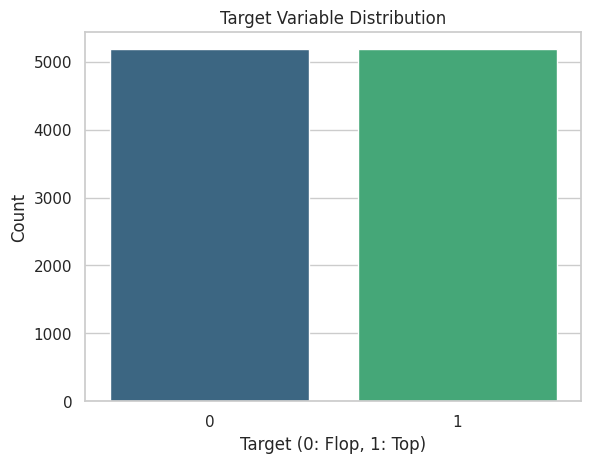

In [ ]:
# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df['target'].value_counts())

# Visualize the target distribution
sns.countplot(data=df, x='target', palette='viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Target (0: Flop, 1: Top)')
plt.ylabel('Count')
plt.show()


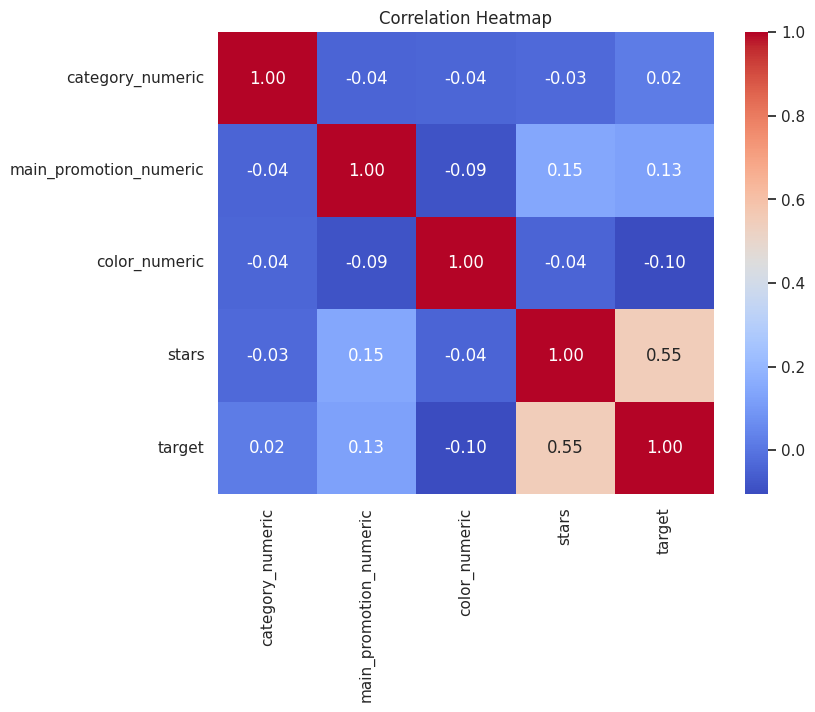

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# **Split the Data into Training and Testing Sets**

In [ ]:
# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train Logistic Regression Model ---
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)

# --- Model Evaluation ---
y_pred_baseline = logistic_model.predict(X_test_scaled)

Training Set Shape: (8296, 4), Testing Set Shape: (2074, 4)


In [ ]:
# Evaluate baseline model
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])

print("\nBaseline Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_baseline:.2f}")
print(f"Precision: {precision_baseline:.2f}")
print(f"Recall: {recall_baseline:.2f}")
print(f"F1 Score: {f1_baseline:.2f}")
print(f"ROC-AUC: {roc_auc_baseline:.2f}")


Baseline Logistic Regression Model Evaluation:
Accuracy: 0.77
Precision: 0.78
Recall: 0.75
F1 Score: 0.77
ROC-AUC: 0.83



Confusion Matrix:
[[810 221]
 [257 786]]


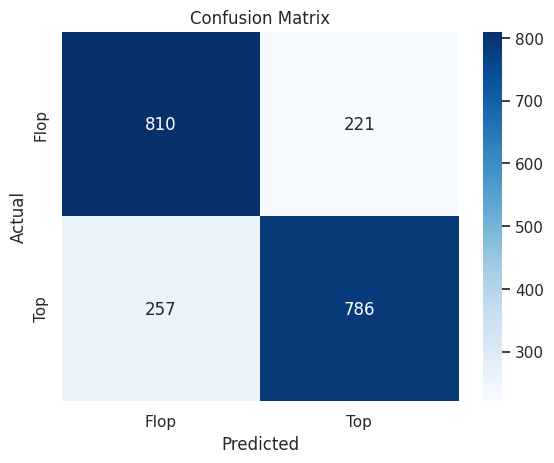

In [ ]:

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flop', 'Top'], yticklabels=['Flop', 'Top'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **Hyperparameter Tuning**

In [ ]:
# Generate a wide range of C values using powers of 10
c_values = np.logspace(-5, 5, num=11)  # 10^-5 to 10^5

# Hyperparameter grid
param_grid = {
    'C': c_values,
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],  # Supports all penalties
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
# --- Step 6: Tuned Model Evaluation ---
best_model = grid_search.best_estimator_

# Predict with tuned model
y_pred_tuned = best_model.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])

print("\nTuned Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_tuned:.2f}")
print(f"Precision: {precision_tuned:.2f}")
print(f"Recall: {recall_tuned:.2f}")
print(f"F1 Score: {f1_tuned:.2f}")
print(f"ROC-AUC: {roc_auc_tuned:.2f}")



Tuned Logistic Regression Model Evaluation:
Accuracy: 0.77
Precision: 0.78
Recall: 0.75
F1 Score: 0.77
ROC-AUC: 0.83


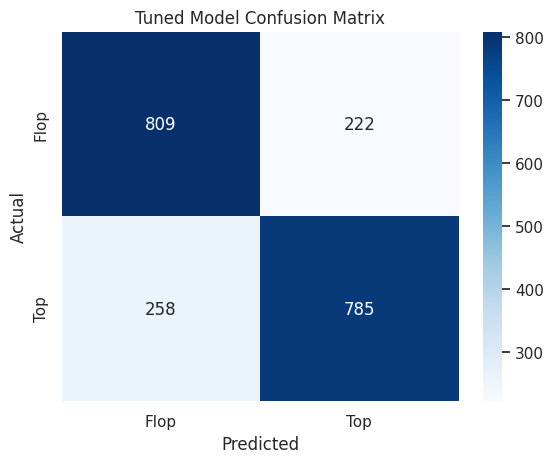

In [ ]:
# Confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Flop', 'Top'], yticklabels=['Flop', 'Top'])
plt.title('Tuned Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Model Performance Comparison:
      Metric  Baseline     Tuned
0   Accuracy  0.769527  0.768563
1  Precision  0.780536  0.779543
2     Recall  0.753595  0.752637
3   F1 Score  0.766829  0.765854
4    ROC-AUC  0.833362  0.833558


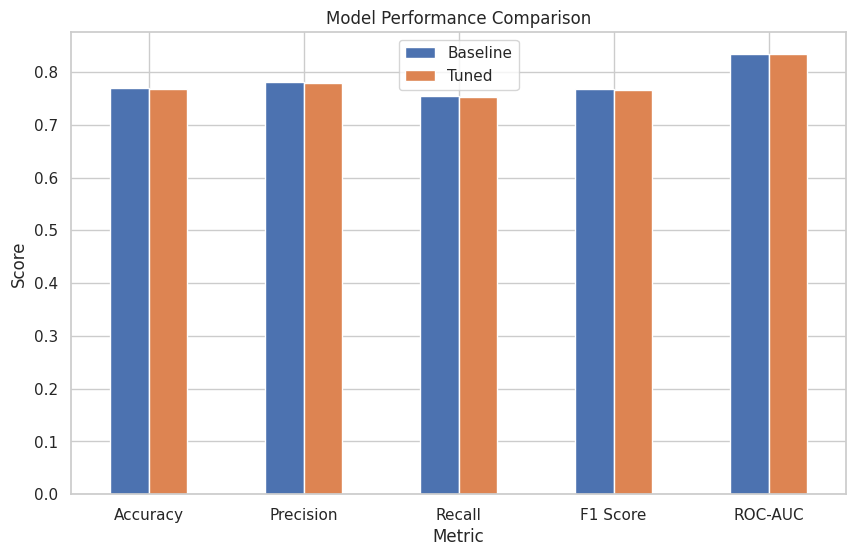

In [ ]:
# --- Step 7: Performance Comparison ---
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Baseline': [accuracy_baseline, precision_baseline, recall_baseline, f1_baseline, roc_auc_baseline],
    'Tuned': [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned, roc_auc_tuned]
})

print("\nModel Performance Comparison:")
print(comparison_df)

# Visualize the comparison
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='best')
plt.xticks(rotation=0)
plt.show()

**Now after training and checking accuracy as well now will make prediction on prediction input file **

In [ ]:

# Step 1: Read the prediction_input file
prediction_input = pd.read_csv('prediction_input.csv')

# Display the initial data
print("Initial Data:")
print(prediction_input.head())

# Step 2: Identify categorical columns
categorical_cols = prediction_input.select_dtypes(include=['object', 'category']).columns
print(f"\nCategorical Columns: {categorical_cols.tolist()}")







Initial Data:
   item_no    category    main_promotion   color  stars
0   405901  Sweatshirt           Catalog    Blue    3.1
1   644275  Polo-Shirt  Frontpage_Header  Yellow    2.6
2   533070       Tunic           Catalog   Green    2.7
3   829436  Polo-Shirt           Catalog  Yellow    2.6
4   801722       Tunic           Catalog  Yellow    4.9

Categorical Columns: ['category', 'main_promotion', 'color']


In [ ]:

# Step 3: Convert Categorical Data to Numerical
# Using Label Encoding and saving the mappings to revert later
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    prediction_input[col] = le.fit_transform(prediction_input[col])
    label_encoders[col] = le  # Store encoder to reverse the encoding later

print("\nData After Label Encoding:")
print(prediction_input.head())


Data After Label Encoding:
   item_no  category  main_promotion  color  stars
0   405901         3               0      1    3.1
1   644275         2               3      9    2.6
2   533070         5               0      3    2.7
3   829436         2               0      9    2.6
4   801722         5               0      9    4.9


In [ ]:

# Step 4: Handle Missing Values
# Fill missing values with mean (for numerical columns)
prediction_input.fillna(prediction_input.mean(), inplace=True)

# Step 5: Scale the Features
# Assuming you have a scaler fitted during training
scaler = StandardScaler()
prediction_input_scaled = scaler.fit_transform(prediction_input.drop(columns=['item_no']))  # 'item_no' is not scaled

# Step 6: Make Predictions
# Assuming 'best_model' is your trained model
predictions = best_model.predict(prediction_input_scaled)
prediction_probs = best_model.predict_proba(prediction_input_scaled)[:, 1]

# Step 7: Add Predictions
# Add predictions and probabilities to the DataFrame
prediction_input['success'] = predictions

In [ ]:

# Map success column to labels
success_mapping = {1: 'Top', 0: 'Fail'}
prediction_input['success'] = prediction_input['success'].map(success_mapping)

# Revert categorical columns to original labels
for col, le in label_encoders.items():
    prediction_input[col] = le.inverse_transform(prediction_input[col])

# Step 8: Prepare Final Output
final_output = prediction_input[['item_no', 'category', 'color', 'main_promotion', 'stars', 'success']]
print("\nFinal Output:")
print(final_output.head())


Final Output:
   item_no    category   color    main_promotion  stars success
0   405901  Sweatshirt    Blue           Catalog    3.1    Fail
1   644275  Polo-Shirt  Yellow  Frontpage_Header    2.6    Fail
2   533070       Tunic   Green           Catalog    2.7    Fail
3   829436  Polo-Shirt  Yellow           Catalog    2.6    Fail
4   801722       Tunic  Yellow           Catalog    4.9     Top


In [ ]:
final_output.shape

(2000, 6)

for 2000 data we have prediction

# Points for Logistic Regression

**Performance Metrics:**

Accuracy: Marginal improvement after tuning (0.7695 → 0.7686), indicating limited gains.
Recall: At 0.7526, it struggles to minimize false negatives, which might be critical for some use cases.


**ROC-AUC:**

A strong 0.833 suggests it can reasonably distinguish between classes, but not as robust as Random Forest or XGBoost.

**Interpretability:**

Logistic Regression excels in explainability, making it ideal when understanding feature importance is critical.
Data Complexity:

Assumes linear relationships, making it unsuitable for capturing non-linear patterns in complex datasets.

**Efficiency:**

Lightweight and fast, suitable for small datasets or when computational resources are limited.

# Conclusion:


Use Logistic Regression for simple datasets, when interpretability or computational efficiency is a priority. However, for higher accuracy, recall, or handling non-linear patterns,**Random Forest or XGBoost** are better choices.